# Machine Predictive Maintenance Classification

This project is a **predictive maintenance model** designed to forecast machine failures based on historical sensor data. It utilizes a **logistic regression model** trained on features such as *air temperature, process temperature, rotational speed, torque*, and *tool wear*. The model is preprocessed using **standard scaling** and **one-hot encoding** to handle *numerical* and *categorical* data. To address **class imbalance**, **Synthetic Minority Over-sampling Technique** (SMOTE) is applied before model training.

Dataset: [link](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification) <br>
Repository: [link](https://github.com/arindal1/Machine-Predictive-Maintenance)

---

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

## Data Preprocessing

In [43]:
data = pd.read_csv('data/predictive_maintenance.csv')

In [44]:
print("Dataset Info:")
data.info()
print("\nSample Data:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB

Sample Data:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2  

#### [checking for missing values]

In [45]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


#### [dropping irrelevant columns like product ID, and UID]

In [46]:
data = data.drop(columns=["UDI", "Product ID"])

## Data Analysis

C:\Users\Arindal Char\AppData\Local\Temp\ipykernel_3640\249545066.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="Target", palette="viridis")


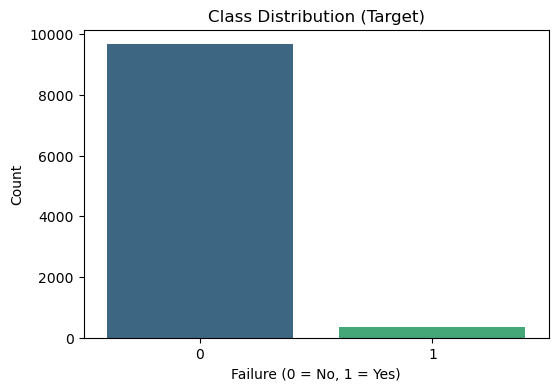

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="Target", palette="viridis")
plt.title("Class Distribution (Target)")
plt.xlabel("Failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

> Due to the **imbalance** in the dataset (only **68 failure** instances out of **2,000 test** samples), we can use techniques like **oversampling (SMOTE)** or **class weighting in the logistic regression** model to handle the *Class Imbalance*.

#### [defining features and target]

In [48]:
X = data.drop(columns=["Target", "Failure Type"])
y = data["Target"]

#### [identify categorical and numerical columns]

In [49]:
categorical_cols = ["Type"]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

#### [Preprocessing: Scaling and One-Hot Encoding]

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), categorical_cols),
    ]
)

In [51]:
preprocessor.fit(X)
X_preprocessed = preprocessor.transform(X)

#### [ Handle class imbalance using SMOTE ]

In [52]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

## Training

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [54]:
print("\nTraining Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (15457, 7)
Testing Data Shape: (3865, 7)


In [55]:
model = LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

#### [ prediction ]

In [56]:
y_pred = model.predict(X_test)

## Evaluation

In [57]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_rep)


Model Performance:
Accuracy: 0.82
F1-Score: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83      1933
           1       0.83      0.82      0.82      1932

    accuracy                           0.82      3865
   macro avg       0.82      0.82      0.82      3865
weighted avg       0.82      0.82      0.82      3865



#### [ confusion matrix ]

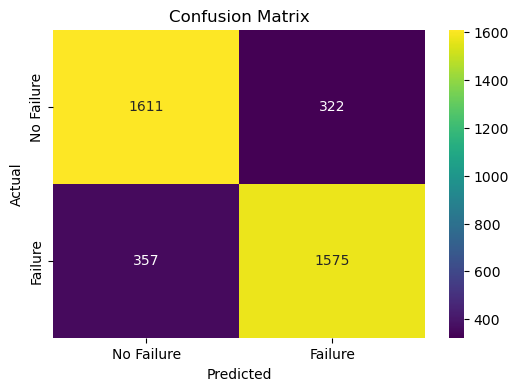

In [58]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### [ saving the model ]

In [59]:
with open("model/downtime_model.pkl", "wb") as file:
    pickle.dump({"model": model, "preprocessor": preprocessor}, file)

print("\nTrained model saved as 'downtime_model.pkl'")


Trained model saved as 'downtime_model.pkl'


#### [ example prediction ]

In [67]:
# Example input values
example_data = {
    "Type": ["M"],
    "Air temperature [K]": [298.1],
    "Process temperature [K]": [308.6],
    "Rotational speed [rpm]": [1551],
    "Torque [Nm]": [42.8],
    "Tool wear [min]": [0],
}

In [68]:
# Convert the example input into a DataFrame
example_df = pd.DataFrame(example_data)

In [69]:
# Preprocess the example data using the same preprocessor
example_preprocessed = preprocessor.transform(example_df)

In [70]:
# Predict the outcome using the trained model
example_prediction = model.predict(example_preprocessed)

In [71]:
# Output the prediction
prediction_label = "Failure" if example_prediction[0] == 1 else "No Failure"
print(f"Prediction for the example data: {prediction_label}")

Prediction for the example data: No Failure


---

#### [ user input ]

In [72]:
import ipywidgets as widgets
from IPython.display import display

In [74]:
type_widget = widgets.Dropdown(
    options=['M', 'L'],
    description='Type:',
)

air_temp_widget = widgets.FloatText(
    value=298.1,
    description='Air Temp [K]:',
)

process_temp_widget = widgets.FloatText(
    value=308.6,
    description='Process Temp [K]:',
)

rotational_speed_widget = widgets.IntText(
    value=1551,
    description='Rotational Speed [rpm]:',
)

torque_widget = widgets.FloatText(
    value=42.8,
    description='Torque [Nm]:',
)

tool_wear_widget = widgets.IntText(
    value=0,
    description='Tool Wear [min]:',
)

predict_button = widgets.Button(description="Predict Failure")

output = widgets.Output()

def on_predict_button_click(b):
    example_data = {
        "Type": [type_widget.value],
        "Air temperature [K]": [air_temp_widget.value],
        "Process temperature [K]": [process_temp_widget.value],
        "Rotational speed [rpm]": [rotational_speed_widget.value],
        "Torque [Nm]": [torque_widget.value],
        "Tool wear [min]": [tool_wear_widget.value],
    }
    example_df = pd.DataFrame(example_data)
    
    example_preprocessed = preprocessor.transform(example_df)
    
    example_prediction = model.predict(example_preprocessed)
    
    prediction_label = "Failure" if example_prediction[0] == 1 else "No Failure"
    
    with output:
        print(f"Prediction for the example data: {prediction_label}")

predict_button.on_click(on_predict_button_click)

display(type_widget, air_temp_widget, process_temp_widget, rotational_speed_widget, torque_widget, tool_wear_widget, predict_button, output)

Dropdown(description='Type:', options=('M', 'L'), value='M')

FloatText(value=298.1, description='Air Temp [K]:')

FloatText(value=308.6, description='Process Temp [K]:')

IntText(value=1551, description='Rotational Speed [rpm]:')

FloatText(value=42.8, description='Torque [Nm]:')

IntText(value=0, description='Tool Wear [min]:')

Button(description='Predict Failure', style=ButtonStyle())

Output()